# Nonlinear Functional Estimation: Functional Detectability and Full Information Estimation
## Numerical Example (Section 6)

In [1]:
import casadi
from casadi.tools import *
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
np.random.seed(1)

## Power System Example

### System Definition

In [3]:
# example with 4 agents
N_agents = 4

model = dict(
    nx = N_agents * 4,
    ny = N_agents * 2,
    nz = 1,
    Ts = 0.01, # discretization time
    M_j = np.array([3,2.5,4,3.5]), # 
    D_j = np.array([1,1.5,1.2,1.4]), #
    abs_V_j = np.array([1.045,0.98,1.033,0.997]), #
    T_j = np.array([4,4,4,4]), #
    R_j = np.array([0.05,0.05,0.05,0.05]), #
    K_j = np.array([2,2,2,2]), #
    B_j = np.array([2,3,2,3]), #
    x_ij = np.array([0.0386,0.0294,0.0596,0.0474]),
    r_ij = np.array([0.004,0.005,0.006,0.0028]),
    theta_0 = np.array([0,0,0,0]),
    N = N_agents, # number of buses
    E = 4, # number of power lines
    edges = [[0,1],[1,2],[2,3],[3,0]], # start and end bus of each edge
    eta = 0.9,
    bound_w = 0.005,
    bound_v = 0.05
)

In [4]:
def compute_P_ij(theta, edge, edge_number, model):
    theta_0 = model['theta_0']
    abs_V_j = model['abs_V_j']
    x_ij = model['x_ij']
    r_ij = model['r_ij']
    
    agent_i = edge[0]
    agent_j = edge[1]
    theta_ij = theta[agent_i] - theta[agent_j]
    theta_ij_0 = theta_0[agent_i] - theta_0[agent_j]
    P_ij = 3 * abs_V_j[agent_i] * abs_V_j[agent_j] / x_ij[edge_number] \
                    * np.sin(theta_ij_0 + theta_ij)
    return P_ij

In [5]:
def continuous_dynamics(state, model):
    N = model['N']
    E = model['E']
    M_j = model['M_j']
    D_j = model['D_j']
    T_j = model['T_j']
    R_j = model['R_j']
    K_j = model['K_j']
    B_j = model['B_j']
    abs_V_j = model['abs_V_j']
    theta_0 = model['theta_0']
    x_ij = model['x_ij']
    r_ij = model['r_ij']
    
    # extract theta, omega, P_L, and P_M from state vector
    theta = state[0:N]
    omega = state[N:2*N]
    P_L = state[2*N:3*N]
    P_M = state[3*N:4*N]
    
    # transmitted power for each power line
    P_ij = np.zeros(E)
    for i in range(E):
        edge = model['edges'][i]
        P_ij[i] = compute_P_ij(theta, edge, i, model)
    
    theta_dot = np.zeros(N)
    omega_dot = np.zeros(N)
    P_L_dot = np.zeros(N)
    P_M_dot = np.zeros(N)
    
    # ODE for states of each bus
    for i in range(N):
        theta_dot[i] = omega[i]
        sum_Pij = 0
        for e in range(E):
            edge = model['edges'][e]
            if edge[1] == i:
                sum_Pij += - P_ij[e]
            elif edge[0] == i:
                sum_Pij += P_ij[e]
        omega_dot[i] = - 1/M_j[i] * (D_j[i] * omega[i] - P_M[i] + P_L[i] + sum_Pij)
        P_L_dot[i] = 0
        P_M_dot[i] = 0

    state_dot = np.zeros(model['nx'])
    
    state_dot[0:N] = theta_dot
    state_dot[N:2*N] = omega_dot
    state_dot[2*N:3*N] = P_L_dot
    state_dot[3*N:4*N] = P_M_dot
    
    state_dot = state_dot
        
    return state_dot, P_ij

In [6]:
def discrete_dynamcis(state, disturbance, model):
    state_dot, P_ij = continuous_dynamics(state, model)
    
    Ts = model['Ts']
    
    state_plus = state + Ts * state_dot + disturbance
    return state_plus, P_ij

In [7]:
def measurement_function(state, noise, model):
    N = model['N']
    
    # extract measurements from state
    P_M = state[3*N:4*N]
    omega = state[N:2*N]
    
    # generate measurement
    ny = model['ny']
    y = np.zeros(ny)
    y[0:P_M.shape[0]] = P_M + noise[0:N]
    y[len(P_M):ny] = omega + noise[N:2*N]
    return y

In [8]:
def functional_output(state, model):
    N = model["N"]
    
    # extract power loads from state
    P_L = state[2*N:3*N]
    z = np.sum(P_L)
    return z

In [9]:
def generate_disturbances(n_w,T,model):
    bound_w = model['bound_w']
    w = np.random.uniform(-bound_w, bound_w,(n_w,T))
    return w

In [10]:
def generate_noise(n_v,T,model):
    bound_v = model['bound_v']
    v = np.random.uniform(-bound_v, bound_v,(n_v,T))
    return v

### Simulation

In [11]:
def simulate_system(x0,w,v,model,T):
    nx = model['nx']
    ny = model['ny']
    nz = model['nz']
    N = model['N']
    E = model['E']
    
    x = np.zeros((nx,T+1))
    x[:,0] = x0
    
    y = np.zeros((ny,T))
    z = np.zeros((nz,T))
    
    branch_flows = np.zeros((E,T))
    
    state = x0
    
    for k in range(T):
        # obtain measurement
        y[:,k] = measurement_function(state, v[:,k], model)
        
        # obtain functional output
        z[:,k] = functional_output(state, model)        
        
        # apply dynamics
        state, P_ij = discrete_dynamcis(state, w[:,k], model)
        x[:,k+1] = state
        branch_flows[:,k] = P_ij
    return x, y, z, branch_flows

In [12]:
## simulation
nsim = 1000
x0 = np.random.uniform(0.5,1.5,model['nx'])
w = generate_disturbances(model['nx'],nsim,model)
v = generate_noise(model['ny'],nsim,model)

x, y, z, branch_flows = simulate_system(x0,w,v,model,nsim)

### Full information estimation

In [13]:
# adapted for use with casadi
def continuous_dynamics_casadi(state, model):
    N = model['N']
    E = model['E']
    M_j = model['M_j']
    D_j = model['D_j']
    T_j = model['T_j']
    R_j = model['R_j']
    abs_V_j = model['abs_V_j']
    theta_0 = model['theta_0']
    x_ij = model['x_ij']
    r_ij = model['r_ij']
    
    # extract theta, omega, P_L, and P_M from state vector
    theta = state[0:N]
    omega = state[N:2*N]
    P_L = state[2*N:3*N]
    P_M = state[3*N:4*N]
    
    # transmitted power for each power line
    edge = model['edges'][0]
    P_ij = compute_P_ij(theta,edge,0,model)
    
    for i in range(1,E):
        edge = model['edges'][i]
        P_ij = casadi.vertcat(P_ij, compute_P_ij(theta,edge,i,model))
        
    omega_dot = MX.sym("omega_dot",N)
    theta_dot = MX.sym("theta_dot",N)
    P_L_dot = MX.sym("P_L_dot",N)
    P_M_dot = MX.sym("P_M_dot",N)
    
    # ODE for states of each bus
    state_dot = omega
    for i in range(N):
        omega_dot_i = - 1/M_j[i] * (D_j[i] * omega[i] - P_M[i] + P_L[i])
        for e in range(E):
            edge = model['edges'][e]
            if edge[1] == i:
                omega_dot_i += - 1/M_j[i] * (- P_ij[e])
            elif edge[0] == i:
                omega_dot_i += - 1/M_j[i] * (P_ij[e])
        state_dot = casadi.vertcat(state_dot,omega_dot_i)
    
    for i in range(N):
        P_L_dot_i = 0
        state_dot = casadi.vertcat(state_dot,P_L_dot_i)
        
    for i in range(N):
        P_M_dot_i = 0
        state_dot = casadi.vertcat(state_dot,P_M_dot_i)
    
    state_dot = state_dot
        
    return state_dot, P_ij

In [14]:
def discrete_dynamcis_casadi(state, disturbance, model):
    state_dot, P_ij = continuous_dynamics_casadi(state, model)
    
    Ts = model['Ts']
    
    state_plus = state + Ts * state_dot + disturbance
    return state_plus, P_ij

In [15]:
def measurement_function_casadi(state, noise, model):
    N = model['N']
    # extract measurements from state
    P_M = state[3*N:4*N]
    omega = state[N:2*N]
    
    # generate measurement
    y = P_M
    y = casadi.vertcat(y,omega)
    return y + noise

In [16]:
def generate_fie(M,model):
    eta = model['eta']
    nx = model['nx']
    ny = model['ny']
    nw = model['nx']
    nv = model['ny']
    
    # variables
    shooting = struct_symMX([entry("x_est", repeat=M+1, shape=nx),
                             entry("y_est", repeat=M, shape=ny),
                             entry("w_est", repeat=M, shape=nw),
                             entry("v_est", repeat=M, shape=nv)])

    # parameters
    parameters = struct_symMX([entry("y_meas", repeat=M, shape=ny),
                               entry("x_prior", repeat=1, shape=nx)])
    
    Q = np.eye(nw + nv)
    Q_w = Q[0:nw,0:nw] / model['bound_w']
    Q_v = Q[nw:nw+nv,nw:nw+nv] / model['bound_v']
    R = np.eye(ny) / model['bound_v']
    P_2 = np.eye(nx) / 1000
    
    objective = 0
    constraints = []
    for k in range(M):
        
        # objective
        delta_y = shooting["y_est"][k] - parameters["y_meas"][k]
        objective += pow(eta, M - k - 1) \
                        * (2 * shooting["w_est"][k][:].reshape((1,nw)) \
                           @ Q_w @ shooting["w_est"][k][:])
        objective += pow(eta, M - k - 1) \
                        * (2 * shooting["v_est"][k][:].reshape((1,nv)) \
                           @ Q_v @ shooting["v_est"][k][:])
        objective += pow(eta, M - k - 1) \
                        * (delta_y.reshape((1,ny)) @ R @ delta_y)
        
        # dynamics
        constraints.append(shooting["x_est"][k+1] \
                           - discrete_dynamcis_casadi(shooting["x_est"][k], \
                             shooting["w_est"][k], model)[0])
        
        # measurements
        constraints.append(shooting["y_est"][k] - \
                           measurement_function_casadi(shooting["x_est"][k], \
                           shooting["v_est"][k], model))
    # prior weighting
    delta_x_prior = shooting["x_est"][0] - parameters["x_prior"][0]
    objective += 2 * pow(eta, M) * delta_x_prior.reshape((1,nx)) \
                 @ P_2 @ delta_x_prior 
    
    nlp = {"x":shooting, "p":parameters, "f":objective, "g":vertcat(*constraints)}
    opts = {"ipopt.print_level":0, "print_time": True, 'ipopt.max_iter':3e3}
    #opts = {}
    solver = nlpsol("nlpsol", "ipopt", nlp, opts)
    
    return [solver, shooting, parameters]

In [17]:
## generate FIE
nsim = 150
fie_struct = []
parameter_struct = []
shooting_struct = []

for k in range(1,nsim+1):
    solver, shooting, parameters = generate_fie(k,model)
    fie_struct.append(solver)
    parameter_struct.append(parameters)
    shooting_struct.append(shooting)

### Linear Estimator

In [18]:
def linear_functional_estimator(y_cur,y_last,model):
    N = model['N']
    z = 0
    for i in range(model['N']):
        z += y_last[i] - model['D_j'][i] * y_last[i+N] - model['M_j'][i] * (y_cur[i+N] - y_last[i+N])/ model['Ts']
    return z

### FIE Simulation

In [19]:
## simulation
x0 = np.array([0,0,0,0,0,0,0,0,1.5,0.5,1.5,0.5,1.2,1.2,1.2,1.2])
w = generate_disturbances(model['nx'],nsim,model)
v = generate_noise(model['ny'],nsim,model)

x, y, z, branch_flows = simulate_system(x0,w,v,model,nsim)

In [ ]:
## estimation
x_est_0 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1])

# FIE
x_fie = np.zeros((model['nx'], nsim))
x_fie[:,0] = x_est_0

z_fie = np.zeros((model['nz'], nsim))
z_fie[:,0] = functional_output(x_est_0,model)

# branch flows
branch_flows_fie = np.zeros((model['E'],nsim))
for i in range(model['E']):
    edge = model['edges'][i]
    branch_flows_fie[i,0] = compute_P_ij(x_fie[0:model['N'],0], edge, i, model)
    
# z linear
z_lin = np.zeros((model['nz'],nsim-2))

# objective value of solver
solver_objective = np.zeros(nsim-1)

# computational times
comp_times = np.zeros(nsim-1)

run_comp_times = True

if run_comp_times:
    n_comp = 10
    comp_times = np.zeros((n_comp,nsim-1))
else:
    n_comp = 1
    comp_times = np.zeros((n_comp,nsim-1))

for k in range(1,nsim):
    current_parameters = parameter_struct[k-1](0)
    current_parameters["y_meas",lambda x: horzcat(*x)] = y[:, 0:k]
    current_parameters["x_prior",lambda x: horzcat(*x)] = x_fie[:,0]
    zero_bound = np.zeros(k*(model['nx']+model['ny']))
    for i in range(n_comp):
        res = fie_struct[k-1](p=current_parameters, lbg=zero_bound, ubg=zero_bound)
        comp_times[i,k-1] = fie_struct[k-1].stats()["t_proc_total"]
    solver_objective[k-1] = res['f']
    if not fie_struct[k-1].stats()["success"]:
        print('FIE not solved successfully')
    solution = shooting_struct[k-1](res['x'])
    x_fie[:,k] = np.squeeze(solution['x_est'][k])
    z_fie[:,k] = functional_output(x_fie[:,k],model)
    
    # reconstruct branch flows
    for i in range(model['E']):
        edge = model['edges'][i]
        branch_flows_fie[i,k] = compute_P_ij(x_fie[0:model['N'],k], edge, i, model)
        
    # obtain linear estimate of z
    if k > 1:
        z_lin[0,k-2] = linear_functional_estimator(y[:,k-1],y[:,k-2],model)
    
    #check_solution(solution,k,model)

In [21]:
from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{times}')

(0.0, 149.0)

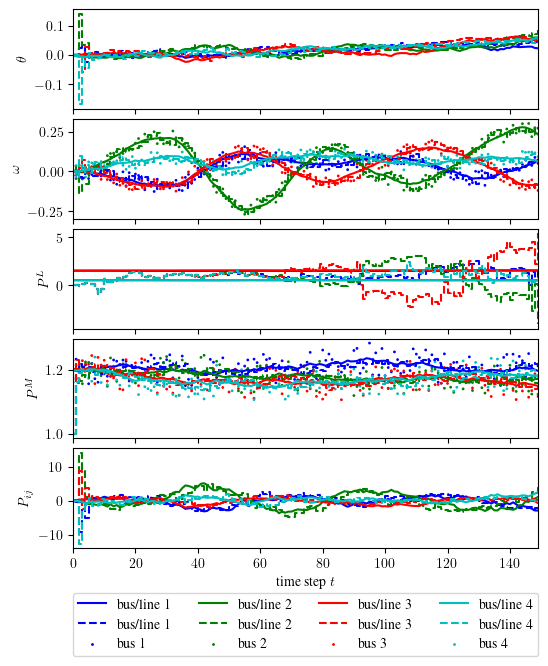

In [22]:
N = model['N']

colors = ['b','g','r','c']
labels_bl = ['bus/line 1', 'bus/line 2', 'bus/line 3', 'bus/line 4']
labels_b = ['bus 1', 'bus 2', 'bus 3', 'bus 4']

## print system evolution
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(6,7))
f.subplots_adjust(hspace=0.1)
plt.rc('text.latex', preamble=r'\usepackage{times}')

# theta
ax1.set_ylabel(r'$\theta$')
#ax1.set_xlabel(r'time step $t$')
for i in range(N):
    ax1.plot(range(nsim+1),x[i,0:nsim+1], color=colors[i])
    ax1.step(np.arange(nsim),x_fie[i,0:nsim], where='post', color=colors[i], linestyle='dashed')
ax1.set_xlim([0,nsim-1])
ax1.xaxis.set_ticklabels([])

# omega
ax2.set_ylabel(r'$\omega$')
#ax2.set_xlabel(r'time step $t$')
for i in range(N):
    ax2.plot(range(nsim+1),x[i+N,:], color=colors[i])
    ax2.scatter(range(nsim),y[i+N,0:nsim], color=colors[i], sizes=np.ones(nsim))
    ax2.step(np.arange(nsim),x_fie[i+N,:], where='post', color=colors[i], linestyle='dashed')
ax2.set_xlim([0,nsim-1])
ax2.xaxis.set_ticklabels([])

# P_L
ax3.set_ylabel(r'$P^L$')
#ax3.set_xlabel(r'time step $t$')
for i in range(N):
    ax3.plot(range(nsim+1),x[i+2*N,:], color=colors[i])
    ax3.step(np.arange(nsim),x_fie[i+2*N,:], where='post', color=colors[i], linestyle='dashed')
ax3.set_xlim([0,nsim-1])
ax3.xaxis.set_ticklabels([])

# P_M
ax4.set_ylabel(r'$P^M$')
#ax4.set_xlabel(r'time step $t$')
for i in range(N):
    ax4.plot(range(nsim+1),x[i+3*N,:], label=labels_bl[i], color=colors[i])
    ax4.step(np.arange(nsim),x_fie[i+3*N,:], where='post', label=labels_bl[i], color=colors[i], linestyle='dashed')
    ax4.scatter(range(nsim),y[i,0:nsim], label=labels_b[i], color=colors[i], sizes=np.ones(nsim))
ax4.set_xlim([0,nsim-1])
ax4.legend(loc='lower center', bbox_to_anchor=(0.5, -2.25), ncol=4)
ax4.xaxis.set_ticklabels([])

# P_ij
ax5.set_ylabel(r'$P_{ij}$')
ax5.set_xlabel(r'time step $t$')
for i in range(N):
    ax5.plot(range(nsim),branch_flows[i,:], color=colors[i])
    ax5.step(np.arange(nsim),branch_flows_fie[i,:], where='post', color=colors[i], linestyle='dashed')
ax5.set_xlim([0,nsim-1])

In [23]:
f.savefig('power_system_states.pdf', bbox_inches='tight', pad_inches=0)

(<matplotlib.patches.Rectangle at 0x7c4747b05090>,
 (<matplotlib.patches.ConnectionPatch at 0x7c4747b05240>,
  <matplotlib.patches.ConnectionPatch at 0x7c4747b05b70>))

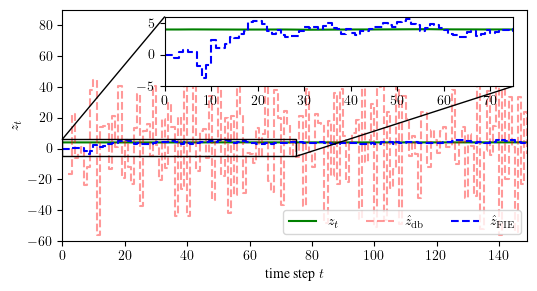

In [24]:
N = model['N']

## print functional values
f, (ax1) = plt.subplots(1,1, figsize=(6,3))
f.subplots_adjust(hspace=0.7)
plt.rc('text.latex', preamble=r'\usepackage{times}')

# functional value
ax1.set_ylabel(r'$z_t$')
ax1.set_xlabel(r'time step $t$')
for i in range(model['nz']):
    ax1.plot(range(nsim),z[i,0:nsim], label=r'$z_t$', color="g")
    ax1.step(np.arange(2,nsim),z_lin[i,:], where='post', label=r'$\hat{z}_{\mathrm{db}}$', color="r", alpha=0.4, linestyle='dashed')
    ax1.step(np.arange(nsim),z_fie[i,0:nsim], where='post', label=r'$\hat{z}_{\mathrm{FIE}}$', color="b", linestyle='dashed')
ax1.set_xlim([0,nsim-1])
ax1.legend(loc='lower left', bbox_to_anchor=(0.46, 0), ncol=4)
ax1.set_ylim([-60,90])

# inset axis
axins = ax1.inset_axes([0.22, 0.67, 0.75, 0.3])
axins.plot(range(nsim),z[i,0:nsim], label=r'$z_t$', color="g")
axins.step(np.arange(nsim),z_fie[i,0:nsim], where='post', label=r'$\hat{z}_{\mathrm{FIE}}$', color="b", linestyle='dashed')
axins.set_xlim(0, 75)
axins.set_ylim(-5, 6)

ax1.indicate_inset_zoom(axins, edgecolor="black", alpha=1)

In [25]:
f.savefig('power_system_functional.pdf', bbox_inches='tight', pad_inches=0)

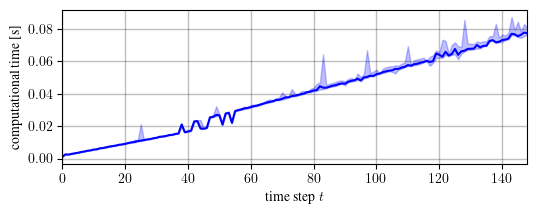

In [26]:
med_time = np.median(comp_times, axis=0)
min_time = np.min(comp_times, axis=0)
max_time = np.max(comp_times, axis=0)

# plot computational times
f, (ax1) = plt.subplots(1,1, figsize=(6,2))
f.subplots_adjust(hspace=0.7)
plt.rc('text.latex', preamble=r'\usepackage{times}')

# functional value
ax1.set_ylabel(r'computational time [s]')
ax1.set_xlabel(r'time step $t$')
ax1.fill_between(range(nsim-1), min_time, max_time, color="b", alpha=0.25)
ax1.plot(range(nsim-1),med_time, color="b")
ax1.set_xlim([0,nsim-2])
ax1.grid(color='k', linestyle='-', linewidth=1, alpha=0.25)
#ax1.set_ylim([0,0.2])

In [ ]:
f.savefig('computational_times.pdf', bbox_inches='tight', pad_inches=0)